In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os

### Iris Dataset 

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [3]:
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### EDA 

In [4]:
df.describe() 

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


(array([50.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0., 50.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

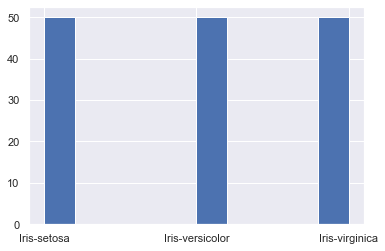

In [5]:
# perfectly balanced dataset 

plt.hist(df["target"])

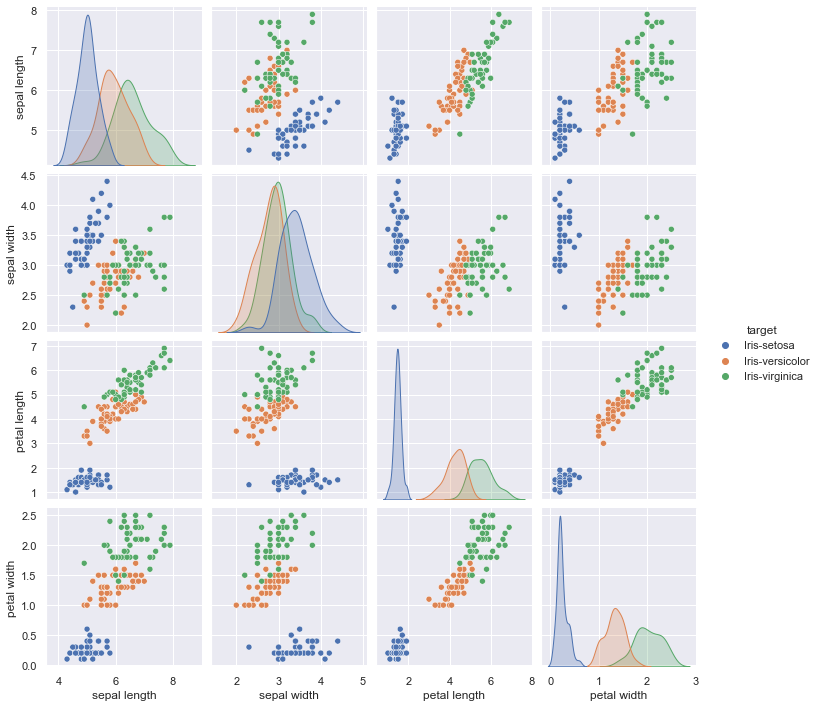

In [6]:
p = sns.pairplot(df, hue = 'target') 

In [7]:
# inplace the categorical targets with numerical values 

df["target"].replace({'Iris-setosa':0,'Iris-versicolor':1, 'Iris-virginica':2},inplace=True) 

### Data Processing (with/without PCA) 

In [8]:
X = df.drop(["target"],axis=1) 
y = df["target"]

In [9]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X) 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size = 0.125, random_state = 42) 

In [11]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(X) 

In [12]:
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y, test_size = 0.2, random_state = 42) 
X_train_transformed, X_eval_transformed, y_train_transformed, y_eval_transformed = train_test_split(X_train_transformed, y_train_transformed, test_size = 0.125, random_state = 42) 

Text(0, 0.5, 'Principal Component 2')

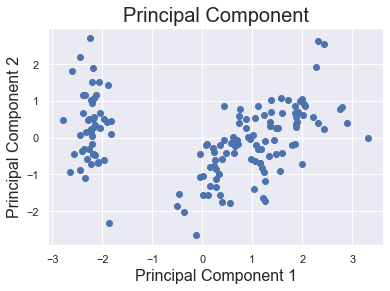

In [13]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1]) 
plt.title("Principal Component", fontsize = 20) 
plt.xlabel("Principal Component 1", fontsize = 16)
plt.ylabel("Principal Component 2", fontsize = 16) 

### Model 

In [14]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression(solver = 'lbfgs') 
model.fit(X_train, y_train) 

LogisticRegression()

In [15]:
training_error = model.score(X_train, y_train) 
eval_error = model.score(X_eval, y_eval) 
test_error = model.score(X_test, y_test) 

In [16]:
# model performance without PCA 

training_error, eval_error, test_error 

(0.9714285714285714, 0.8666666666666667, 0.9666666666666667)

In [17]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression(solver = 'lbfgs') 
model.fit(X_train_transformed, y_train_transformed) 

LogisticRegression()

In [18]:
training_error = model.score(X_train_transformed, y_train_transformed) 
eval_error = model.score(X_eval_transformed, y_eval_transformed) 
test_error = model.score(X_test_transformed, y_test_transformed) 

In [19]:
# model performance with PCA 

training_error, eval_error, test_error 

(0.9714285714285714, 0.8666666666666667, 0.9666666666666667)

### Neural Net 

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset 

In [15]:
X = torch.tensor(X) 
y = torch.tensor(y.values)

In [16]:
data = TensorDataset(X.float(), y.long())

In [17]:
len(data), data[0][0].shape, data[0][1].shape 

(150, torch.Size([4]), torch.Size([]))

In [18]:
training_set, test_set = torch.utils.data.random_split(data, [120, 30]) 
training_set, eval_set = torch.utils.data.random_split(training_set, [105, 15]) 

In [19]:
train_loader = DataLoader(training_set, batch_size = 32, shuffle=True, pin_memory=True) 
eval_loader = DataLoader(eval_set, batch_size = 5, shuffle=False, pin_memory=True) 
test_loader = DataLoader(test_set, batch_size = 15, shuffle=False, pin_memory=True) 

In [20]:
def train_epoch(model, train_loader, optimizer, criterion): 
    preds = []
    trues = []
    training_loss = [] 
    count = 0
    model.train()
    for X, y in train_loader: 
        X, y = X.to(device), y.unsqueeze(dim=1).to(device)
        pred = model(X) 
        
        loss = 0
#         print(pred.shape, y.shape)
        loss = criterion(pred, y.squeeze(1))
        training_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return preds, trues, np.mean(training_loss) 

In [21]:
def eval_epoch(model, val_loader, criterion): 
    preds = []
    trues = []
    eval_loss = []
    
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.unsqueeze(dim=1).to(device)
            pred = model(X)
            
            loss = 0
            loss = criterion(pred, y.squeeze(1)) 
            eval_loss.append(loss.item()) 
            
    return preds, trues, np.mean(eval_loss) 

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module): 
    def __init__(self, input_dim = 4, hidden_dim = 64, output_dim = 3): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(inplace=True), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(inplace=True), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(inplace=True), 
            nn.Linear(hidden_dim, output_dim) 
        )
        
    def forward(self, x): 
        output = self.model(x) 

        return output

In [23]:
import time 
device = "cuda" 

model = MLP(4, 32, 3).to(device)
num_epoch = 200
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))
best_loss = 10000   
train_losses = []
val_losses = [] 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss = eval_epoch(model, eval_loader, criterion) 
    val_losses.append(val_loss)
    if val_loss <= best_loss: 
        best_loss = val_loss 
        best_model = model 
    end = time.time()
    print("Epoch:", epoch, "completed in:", (end - start), "s. Training loss:", train_loss, ". Val loss:", val_loss) 
    if (len(train_losses) > 50 and np.mean(val_losses[-5:]) >= np.mean(val_losses[-10:-5])):
        break
    scheduler.step() 

2371
Epoch: 1 completed in: 0.6019647121429443 s. Training loss: 1.0389530062675476 . Val loss: 0.8389005263646444
Epoch: 2 completed in: 0.010000228881835938 s. Training loss: 0.7396819889545441 . Val loss: 0.4762965639432271
Epoch: 3 completed in: 0.009999990463256836 s. Training loss: 0.48982176929712296 . Val loss: 0.3213190361857414
Epoch: 4 completed in: 0.010000228881835938 s. Training loss: 0.330671101808548 . Val loss: 0.23250033954779306
Epoch: 5 completed in: 0.009999752044677734 s. Training loss: 0.25868166983127594 . Val loss: 0.14294197410345078
Epoch: 6 completed in: 0.01100015640258789 s. Training loss: 0.15173255931586027 . Val loss: 0.06663160150249799
Epoch: 7 completed in: 0.009999752044677734 s. Training loss: 0.1222255527973175 . Val loss: 0.04258432860175768
Epoch: 8 completed in: 0.010000228881835938 s. Training loss: 0.1063920296728611 . Val loss: 0.013396018805603186
Epoch: 9 completed in: 0.010001897811889648 s. Training loss: 0.13943232968449593 . Val loss: 

In [28]:
preds = [] 
count = 0
with torch.no_grad():
    for X_t, y_t in training_set: 
        X_t, y_t = X_t.to(device), y_t.to(device)
        y_hat = model(X_t)
#         preds.append(y_hat.argmax().item())
        if (y_hat.argmax().item() == y_t): count += 1 

In [29]:
count / len(training_set)

0.9904761904761905

In [30]:
preds = [] 
count = 0
with torch.no_grad():
    for X_t, y_t in eval_set: 
        X_t, y_t = X_t.to(device), y_t.to(device)
        y_hat = model(X_t)
#         preds.append(y_hat.argmax().item())
        if (y_hat.argmax().item() == y_t): count += 1 

In [31]:
count / len(eval_set)

1.0

In [32]:
preds = [] 
count = 0
with torch.no_grad():
    for X_t, y_t in test_set: 
        X_t, y_t = X_t.to(device), y_t.to(device)
        y_hat = model(X_t)
#         preds.append(y_hat.argmax().item())
        if (y_hat.argmax().item() == y_t): count += 1 

In [33]:
count

29

In [34]:
count / len(test_set)

0.9666666666666667

In [35]:
29 / 30

0.9666666666666667

In [34]:
X = torch.tensor(X_transformed) 
# y = torch.tensor(y)

In [35]:
data = TensorDataset(X.float(), y.long())

In [36]:
training_set, test_set = torch.utils.data.random_split(data, [120, 30]) 
training_set, eval_set = torch.utils.data.random_split(training_set, [105, 15]) 

In [37]:
train_loader = DataLoader(training_set, batch_size = 32, shuffle=True, pin_memory=True) 
eval_loader = DataLoader(eval_set, batch_size = 5, shuffle=False, pin_memory=True) 
test_loader = DataLoader(test_set, batch_size = 15, shuffle=False, pin_memory=True) 

In [39]:
import time 
device = "cuda" 

model = MLP(3, 32, 3).to(device)
num_epoch = 200
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))
best_loss = 10000   
train_losses = []
val_losses = [] 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss = eval_epoch(model, eval_loader, criterion) 
    val_losses.append(val_loss)
    if val_loss <= best_loss: 
        best_loss = val_loss 
        best_model = model 
    end = time.time()
    print("Epoch:", epoch, "completed in:", (end - start), "s. Training loss:", train_loss, ". Val loss:", val_loss) 
    if (len(train_losses) > 50 and np.mean(val_losses[-5:]) >= np.mean(val_losses[-10:-5])):
        break
    scheduler.step() 

2339
Epoch: 1 completed in: 0.02547907829284668 s. Training loss: 1.0481512248516083 . Val loss: 0.9253096580505371
Epoch: 2 completed in: 0.01797795295715332 s. Training loss: 0.7757991552352905 . Val loss: 0.6745340426762899
Epoch: 3 completed in: 0.01602482795715332 s. Training loss: 0.5302838161587715 . Val loss: 0.4992327590783437
Epoch: 4 completed in: 0.016999244689941406 s. Training loss: 0.3748760521411896 . Val loss: 0.38438446323076886
Epoch: 5 completed in: 0.015998363494873047 s. Training loss: 0.28198738768696785 . Val loss: 0.2964563270409902
Epoch: 6 completed in: 0.018000125885009766 s. Training loss: 0.22230970114469528 . Val loss: 0.22120156387488046
Epoch: 7 completed in: 0.016002178192138672 s. Training loss: 0.15869053080677986 . Val loss: 0.15225104242563248
Epoch: 8 completed in: 0.01799941062927246 s. Training loss: 0.11428666114807129 . Val loss: 0.14853176722923914
Epoch: 9 completed in: 0.015999555587768555 s. Training loss: 0.08172140270471573 . Val loss: 0

In [46]:
preds = [] 
count = 0
with torch.no_grad():
    for X_t, y_t in training_set: 
        X_t, y_t = X_t.to(device), y_t.to(device)
        y_hat = model(X_t)
#         preds.append(y_hat.argmax().item())
        if (y_hat.argmax().item() == y_t): count += 1 

In [47]:
count / len(training_set) 

0.9809523809523809

In [48]:
preds = [] 
count = 0
with torch.no_grad():
    for X_t, y_t in eval_set: 
        X_t, y_t = X_t.to(device), y_t.to(device)
        y_hat = model(X_t)
#         preds.append(y_hat.argmax().item())
        if (y_hat.argmax().item() == y_t): count += 1 

In [49]:
count / len(eval_set) 

0.9333333333333333

In [40]:
preds = [] 
count = 0
with torch.no_grad():
    for X_t, y_t in test_set: 
        X_t, y_t = X_t.to(device), y_t.to(device)
        y_hat = model(X_t)
#         preds.append(y_hat.argmax().item())
        if (y_hat.argmax().item() == y_t): count += 1 

In [41]:
count / len(test_set) 

1.0

In [39]:
np.sqrt(324)

18.0

In [40]:
18 ** 2

324